In [2]:
import numpy as np
from sklearn import preprocessing, decomposition

train_data = np.load('MLProject2024/fashion_train.npy') 
test_data = np.load('MLProject2024/fashion_test.npy')
train_images = train_data[:, :-1]
test_images = test_data[:, :-1]
train_labels = train_data[:, -1].astype(int)
test_labels = test_data[:, -1].astype(int)

# Apply PCA and combine features with labels
pca = decomposition.PCA(16)
pca_train = pca.fit_transform(train_images)
pca_test = pca.transform(test_images)
train_data_pca = np.hstack((pca_train, train_labels.reshape(-1, 1)))

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [5]:
# Convert data and labels to tensors
X_train = torch.tensor(pca_train, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)

X_test = torch.tensor(pca_test, dtype=torch.float32)
y_test = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDataset objects
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes):
        super(Net, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        layers.append(nn.Linear(in_size, num_classes))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)


In [ ]:
accuracyDict = {}
num_classes = len(np.unique(train_labels))
batch_size = 64
num_epochs = 200  # Adjust as needed for time constraints

for i in range(5, 20):
    print(f"\nProcessing PCA with {i} components...")
    
    # Apply PCA
    pca = decomposition.PCA(n_components=i)
    pca_train = pca.fit_transform(train_images)
    pca_test = pca.transform(test_images)
    
    # Convert data to tensors
    X_train = torch.tensor(pca_train, dtype=torch.float32)
    y_train = torch.tensor(train_labels, dtype=torch.long)
    X_test = torch.tensor(pca_test, dtype=torch.float32)
    y_test = torch.tensor(test_labels, dtype=torch.long)
    
    # Create datasets and loaders
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize the model
    input_size = i
    hidden_sizes = [64, 32]  # You can adjust this
    model = Net(input_size, hidden_sizes, num_classes)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters()) 
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == y_test).sum().item() / y_test.size(0)
        accuracyDict[i] = accuracy
        print(f"Accuracy with {i} PCA components: {accuracy:.4f}")



Processing PCA with 5 components...
Epoch [1/200], Loss: 4.7289
Epoch [2/200], Loss: 1.7094
Epoch [3/200], Loss: 1.3638
Epoch [4/200], Loss: 1.0936
Epoch [5/200], Loss: 1.0486
Epoch [6/200], Loss: 0.9824
Epoch [7/200], Loss: 0.9710
Epoch [8/200], Loss: 0.8652
Epoch [9/200], Loss: 0.8551
Epoch [10/200], Loss: 0.7576
Epoch [11/200], Loss: 0.7884
Epoch [12/200], Loss: 0.7307
Epoch [13/200], Loss: 0.6895
Epoch [14/200], Loss: 0.6791
Epoch [15/200], Loss: 0.6402
Epoch [16/200], Loss: 0.6562
Epoch [17/200], Loss: 0.6325
Epoch [18/200], Loss: 0.6186
Epoch [19/200], Loss: 0.6345
Epoch [20/200], Loss: 0.6079
Epoch [21/200], Loss: 0.6146
Epoch [22/200], Loss: 0.6030
Epoch [23/200], Loss: 0.5881
Epoch [24/200], Loss: 0.5745
Epoch [25/200], Loss: 0.6042
Epoch [26/200], Loss: 0.5992
Epoch [27/200], Loss: 0.5687
Epoch [28/200], Loss: 0.5661
Epoch [29/200], Loss: 0.5598
Epoch [30/200], Loss: 0.5471
Epoch [31/200], Loss: 0.5681
Epoch [32/200], Loss: 0.5526
Epoch [33/200], Loss: 0.5593
Epoch [34/200],

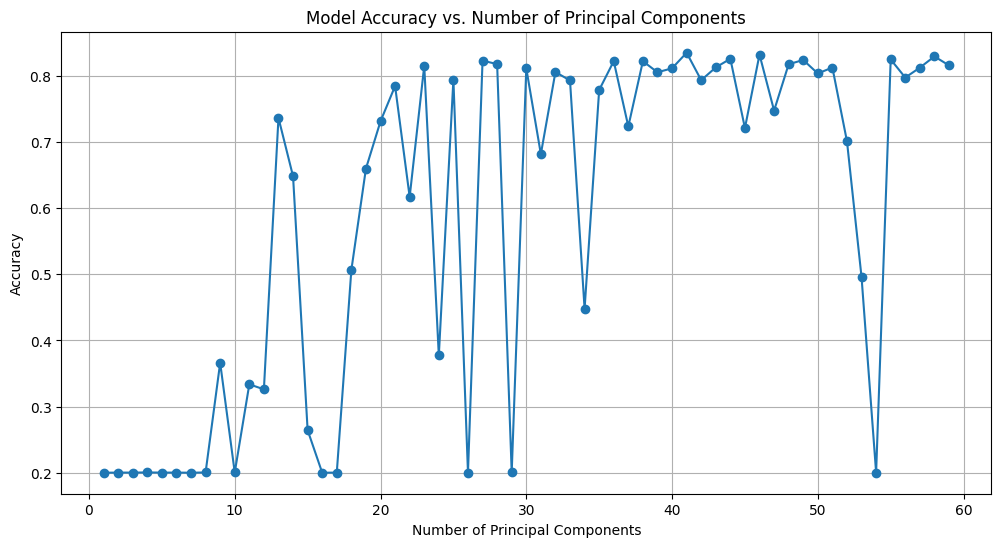

In [8]:
import matplotlib.pyplot as plt


# Plotting the accuracies
components = list(accuracyDict.keys())
accuracies = list(accuracyDict.values())

plt.figure(figsize=(12, 6))
plt.plot(components, accuracies, marker='o')
plt.title('Model Accuracy vs. Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()
